Import of packages

In [93]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
import seaborn as sns

from keras.models import Sequential
from keras.optimizers import Adam
from keras.utils import to_categorical
from keras.callbacks import EarlyStopping
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Input, BatchNormalization, AveragePooling2D
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Dropout
from tensorflow.keras.regularizers import l1_l2

Function for loading the labeled dataset in correct order

In [94]:
def load_data(dataset_dir, labes_dir):
    # Load the labels
    labels_df = pd.read_csv(labes_dir)

    # Sort labels by ID to ensure the order matches the .npy file order
    labels_df = labels_df.sort_values('ID').reset_index(drop=True)

    # Initialize lists to collect data and labels
    data_list = []
    labels_list = []

    # Loop over IDs in order
    for idx, row in labels_df.iterrows():
        file_path = os.path.join(dataset_dir, f"{row['ID']}.npy")
        data = np.load(file_path)
        data_list.append(data)
        labels_list.append(row['target'])

    # Convert to numpy arrays
    dataset = np.array(data_list)
    dataset_labels = np.array(labels_list)
    
    return dataset, dataset_labels

Loading the dataset

In [95]:
TRAIN_DIR = 'C:/Users/Martin/Documents/REPO/MPA-MLF/Project/MPA-MLF_DATA_NEW/Train/'
TEST_DIR = 'C:/Users/Martin/Documents/REPO/MPA-MLF/Project/MPA-MLF_DATA_NEW/Test/'
LABEL_PATH = 'C:/Users/Martin/Documents/REPO/MPA-MLF/Project/MPA-MLF_DATA_NEW/label_train.csv'
EMPTY_LABEL_PATH = 'C:/Users/Martin/Documents/REPO/MPA-MLF/Project/MPA-MLF_DATA_NEW/test_format.csv'

dataset, dataset_labels = load_data(TRAIN_DIR, LABEL_PATH)
submition_data, submition_data_labels = load_data(TEST_DIR, EMPTY_LABEL_PATH)

print(f"Data shape: {dataset.shape}")
print(f"Labels shape: {dataset_labels.shape}")
print(f"Kaggle data shape: {submition_data.shape}")
print(f"Kaggle labels shape: {submition_data_labels.shape}")

nodeB_0 = dataset[dataset_labels == 0]
nodeB_1 = dataset[dataset_labels == 1]
nodeB_2 = dataset[dataset_labels == 2]
print("Num of nodeB_0:", nodeB_0.shape[0], "\nNum of nodeB_1:", nodeB_1.shape[0], "\nNum of nodeB_2:", nodeB_2.shape[0], "\n")

Data shape: (1491, 72, 48)
Labels shape: (1491,)
Kaggle data shape: (120, 72, 48)
Kaggle labels shape: (120,)
Num of nodeB_0: 1209 
Num of nodeB_1: 141 
Num of nodeB_2: 141 



Visualise one train LTE frame sample

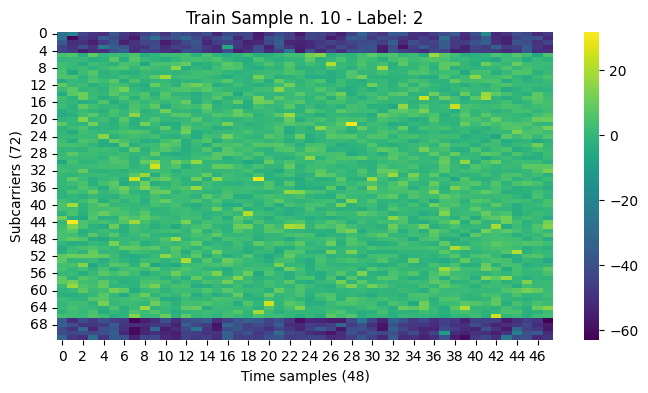

In [96]:
i = 10
plt.figure(figsize=(8, 4))
sns.heatmap(dataset[i], cmap='viridis')
plt.title(f"Train Sample n. {i} - Label: {int(dataset_labels[i])}")
plt.xlabel("Time samples (48)")
plt.ylabel("Subcarriers (72)")
plt.show()

In [97]:
x_train, x_test, y_train, y_test = train_test_split(dataset, dataset_labels, test_size=0.1, random_state=42)

x_eval = submition_data

x_train_aug, x_val, y_train_aug, y_val = train_test_split(
    x_train, 
    y_train, 
    test_size=0.3, 
    stratify=y_train, 
    random_state=42
)

print("x_test shape:", x_test.shape)
print("x_train before augmentation shape:", x_train_aug.shape)
print("x_val validation shape:", x_val.shape)

x_test shape: (150, 72, 48)
x_train before augmentation shape: (938, 72, 48)
x_val validation shape: (403, 72, 48)


In [98]:
def apply_frequency_selective_fading_db(samples, min_db=-5, max_db=5):
    N, H, W = samples.shape
    fading_db = np.random.uniform(min_db, max_db, size=(N, H, 1))
    return samples + fading_db

In [99]:
def augment_data(dataset, labels, multiplier = 2, std1 = 3, std2 = 5):
    nodeB_0 = dataset[labels == 0]
    nodeB_1 = dataset[labels == 1]
    nodeB_2 = dataset[labels == 2]

    #plt.hist(dataset.flatten(order='C'), bins='auto')

    print("Training")
    print("Num of nodeB_0:", nodeB_0.shape[0], "\nNum of nodeB_1:", nodeB_1.shape[0], "\nNum of nodeB_2:", nodeB_2.shape[0], "\n")
    
    for k in range(multiplier):
        nodeB_0 = nodeB_0 + np.random.normal(0, std1, nodeB_0.shape)
        dataset = np.append(dataset, nodeB_0, 0)
        labels = np.append(labels, np.zeros(nodeB_0.shape[0]))
        
    N_nodeB_0 = np.count_nonzero(labels == 0)

    print("Enlargin NB1 by: ", N_nodeB_0//nodeB_1.shape[0])
    for k in range(N_nodeB_0//nodeB_1.shape[0]):
        nodeB_1 = nodeB_1 + np.random.normal(0, k//std2, nodeB_1.shape)
        dataset = np.append(dataset, nodeB_1, 0)
        labels = np.append(labels, np.ones(nodeB_1.shape[0]))

    print("Enlargin NB2 by: ", N_nodeB_0//nodeB_2.shape[0])
    for k in range(N_nodeB_0//nodeB_2.shape[0]):
        nodeB_2 = nodeB_2 + np.random.normal(0, k//std2, nodeB_2.shape)
        dataset = np.append(dataset, nodeB_2, 0)
        labels = np.append(labels, 2 * np.ones(nodeB_2.shape[0]))    
        
    print("Enlarged dataset")
    print("Num of nodeB_0:", np.count_nonzero(labels == 0), "\nNum of nodeB_1:", np.count_nonzero(labels == 1), "\nNum of nodeB_2:", np.count_nonzero(labels == 2), "\n")

    print("Final size of dataset: ", dataset.shape)
    print("Final size of labels: ", labels.shape)
    return dataset, labels

In [100]:
x_train_aug, y_train_aug = augment_data(x_train_aug, y_train_aug, 1, 3, 3)
#x_test, y_test = augment_data(x_test, y_test, 1, 1, 3)

""" nodeB_0 = x_train_aug[y_train_aug == 0]
x_train_aug = np.append(x_train_aug, apply_frequency_selective_fading_db(nodeB_0, -3, 3), 0)
y_train_aug = np.append(y_train_aug, 0 * np.ones(nodeB_0.shape[0]))    

nodeB_1 = x_train_aug[y_train_aug == 1]
x_train_aug = np.append(x_train_aug, apply_frequency_selective_fading_db(nodeB_1, -3, 3), 0)
y_train_aug = np.append(y_train_aug, 0 * np.ones(nodeB_1.shape[0]))   

nodeB_2 = x_train_aug[y_train_aug == 2]
x_train_aug = np.append(x_train_aug, apply_frequency_selective_fading_db(nodeB_2, -3, 3), 0)
y_train_aug = np.append(y_train_aug, 0 * np.ones(nodeB_2.shape[0]))    """

print("Final size of dataset: ", x_train_aug.shape)
print("Final size of labels: ", y_train_aug.shape)

Training
Num of nodeB_0: 760 
Num of nodeB_1: 86 
Num of nodeB_2: 92 

Enlargin NB1 by:  17
Enlargin NB2 by:  16
Enlarged dataset
Num of nodeB_0: 1520 
Num of nodeB_1: 1548 
Num of nodeB_2: 1564 

Final size of dataset:  (4632, 72, 48)
Final size of labels:  (4632,)
Final size of dataset:  (4632, 72, 48)
Final size of labels:  (4632,)


In [101]:
# normalization of training data
x_train_mean = np.mean(x_train_aug)
x_train_deviation = np.std(x_train_aug)
x_train_normalized = (x_train_aug - x_train_mean) / x_train_deviation

# normalization of validation data
x_val_mean = np.mean(x_val)
x_val_deviation = np.std(x_val)
x_val_normalized = (x_val - x_val_mean) / x_val_deviation

# normalization of test data
x_test_mean = np.mean(x_test)
x_test_deviation = np.std(x_test)
x_test_normalized = (x_test - x_test_mean) / x_test_deviation

# normalization of submition data
x_eval_mean = np.mean(x_eval)
x_eval_deviation = np.std(x_eval)
x_eval_normalized = (x_eval - x_eval_mean) / x_eval_deviation

x_train_normalized = x_train_normalized.reshape(-1, 72, 48, 1)
x_val_normalized = x_val_normalized.reshape(-1, 72, 48, 1)
x_test_normalized = x_test_normalized.reshape(-1, 72, 48, 1)
x_eval_normalized = x_eval_normalized.reshape(-1, 72, 48, 1)

y_train_encoded = to_categorical(y_train_aug, num_classes=3)
y_val_encoded = to_categorical(y_val, num_classes=3)
y_test_encoded = to_categorical(y_test, num_classes=3)

In [102]:
model = Sequential()

model.add(Input(shape=(72, 48, 1)))

model.add(Conv2D(64, kernel_size=(5,5), activation = 'relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Conv2D(32, kernel_size=(3,3), activation = 'relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Conv2D(16, kernel_size=(3,3), activation = 'relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Flatten())

#model.add(BatchNormalization())
model.add(Dense(64, activation='relu')) #128
model.add(Dropout(0.3))
model.add(Dense(32, activation='relu'))
#model.add(BatchNormalization())

model.add(Dense(3, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate = 0.001), metrics=['accuracy'])

model.summary()

early_stopping = EarlyStopping(monitor='val_loss', min_delta=0.001, patience=7, verbose=1, restore_best_weights=False)

Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_24 (Conv2D)              │ (None, 68, 44, 64)     │         1,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_24 (MaxPooling2D) │ (None, 34, 22, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_25 (Conv2D)              │ (None, 32, 20, 32)     │        18,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_25 (MaxPooling2D) │ (None, 16, 10, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_26 (Conv2D)              │ (None, 14, 8, 16)      │         4,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_26 (MaxPooling2D) │ (None, 7, 4, 16)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_8 (Flatten)             │ (None, 448)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_24 (Dense)                │ (None, 64)             │        28,736 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_25 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_26 (Dense)                │ (None, 3)              │            99 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 55,667 (217.45 KB)

 Trainable params: 55,667 (217.45 KB)

 Non-trainable params: 0 (0.00 B)

In [103]:
history = model.fit(
    x_train_normalized, 
    y_train_encoded, 
    epochs=50, 
    batch_size=20, 
    validation_data=(x_val_normalized, y_val_encoded),
    callbacks=[early_stopping]
)

Epoch 1/50
232/232 ━━━━━━━━━━━━━━━━━━━━ 6s 20ms/step - accuracy: 0.5647 - loss: 0.8580 - val_accuracy: 0.9926 - val_loss: 0.0550
Epoch 2/50
232/232 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - accuracy: 0.9280 - loss: 0.2009 - val_accuracy: 0.9901 - val_loss: 0.0232
Epoch 3/50
232/232 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - accuracy: 0.9541 - loss: 0.1344 - val_accuracy: 0.9851 - val_loss: 0.0312
Epoch 4/50
232/232 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - accuracy: 0.9621 - loss: 0.1155 - val_accuracy: 0.9975 - val_loss: 0.0131
Epoch 5/50
232/232 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - accuracy: 0.9729 - loss: 0.0784 - val_accuracy: 0.9901 - val_loss: 0.0255
Epoch 6/50
232/232 ━━━━━━━━━━━━━━━━━━━━ 5s 19ms/step - accuracy: 0.9751 - loss: 0.0733 - val_accuracy: 0.9901 - val_loss: 0.0182
Epoch 7/50
232/232 ━━━━━━━━━━━━━━━━━━━━ 5s 19ms/step - accuracy: 0.9878 - loss: 0.0361 - val_accuracy: 0.9851 - val_loss: 0.0377
Epoch 8/50
232/232 ━━━━━━━━━━━━━━━━━━━━ 5s 20ms/step - accuracy: 0.9866 - loss: 0.0418 - val_accu

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.9978 - loss: 0.0228    
Test loss: 0.06604425609111786
Test accuracy: 99.33333396911621 %
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


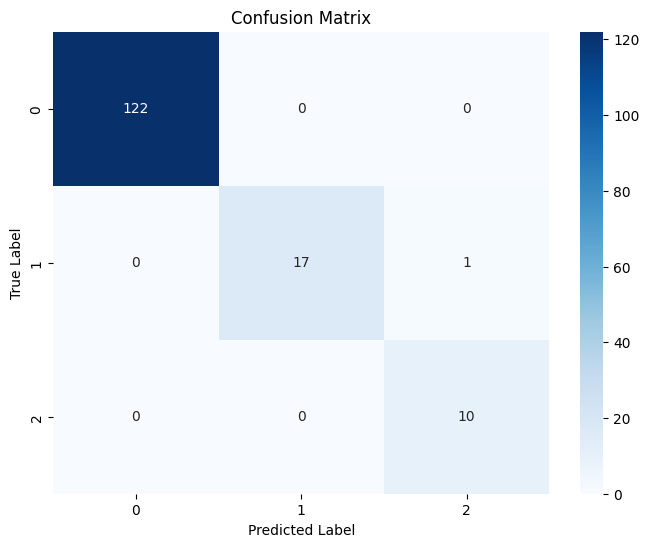

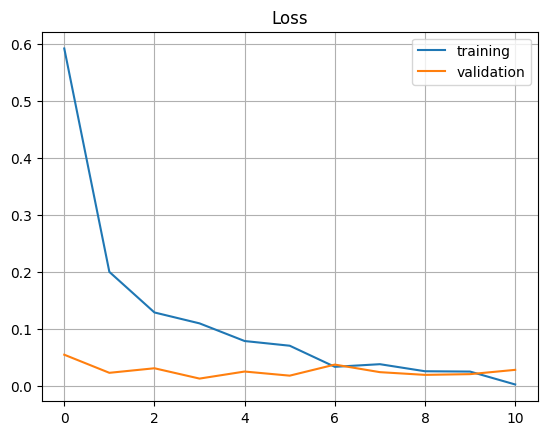

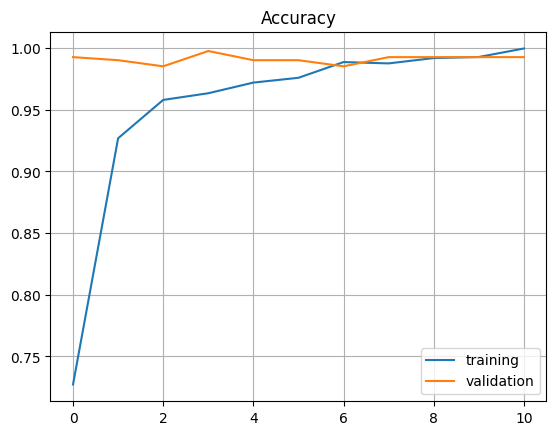

In [104]:
score = model.evaluate(x_test_normalized, y_test_encoded, verbose=1)
print('Test loss:', score[0])
print(f'Test accuracy: {score[1]*100} %')

y_pred_probs = model.predict(x_test_normalized)  # Probabilities
y_pred_classes = np.argmax(y_pred_probs, axis=1)  # Convert to class labels
y_true = np.argmax(y_test_encoded, axis=1)  # True labels

conf_matrix = confusion_matrix(y_true, y_pred_classes) # Compute confusion matrix

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

plt.figure()
plt.title('Loss')
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['training', 'validation'])
plt.grid('both')
plt.figure()
plt.title('Accuracy')
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.legend(['training', 'validation'])
plt.grid('both')

In [105]:
y_pred = model.predict(x_eval_normalized)
#print(y_pred)
y_pred_classes = np.argmax(y_pred, axis=1)
print(y_pred_classes)

import csv
with open('label_test_MT_v0.csv', mode='w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(['ID', 'target'])
    for i, value in enumerate(y_pred_classes):
        writer.writerow([i, value])

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
[1 0 1 2 0 0 2 0 2 0 1 1 1 0 1 2 0 2 2 2 0 0 2 1 0 0 2 1 1 1 2 0 2 2 2 0 2
 0 0 0 1 2 1 0 1 2 1 0 2 1 1 0 2 0 0 1 0 1 2 0 2 1 1 2 1 1 2 1 0 2 1 1 2 2
 2 1 1 2 2 2 0 1 2 2 0 2 0 1 0 2 2 1 2 0 0 0 0 2 0 0 0 0 1 1 2 2 1 0 1 2 2
 0 1 1 0 1 2 0 0 1]
